# Confusion matrix

In [16]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from tqdm import tqdm  # Import tqdm for the progress bar

In [67]:
## Load the models
def load_model(model_name, directory="models"):
    # Initiate pretrained model
    if "resnet18" in model_name:
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif "resnet50" in model_name:
        model = models.resnet50(weights='DEFAULT')
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif "alexnet" in model_name:
        model = models.alexnet(weights='DEFAULT')
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    elif "efficientnet_b0" in model_name:
        model = models.efficientnet_b0(weights='DEFAULT')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    elif "efficientnet_b1" in model_name:
        model = models.efficientnet_b1(weights='DEFAULT')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    elif "efficientnet_b2" in model_name:
        model = models.efficientnet_b2(weights='DEFAULT')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    else:
        raise ValueError("Invalid model name")
    
    # Load the trained model weights
    model.load_state_dict(torch.load(os.path.join(directory, f"{model_name}_model.pt"), weights_only=True))
    
    # link the model to the CPU or CUDA
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, device

## Load images
def prepare_dataloader(test_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader, test_dataset.classes

## Evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", colour="#3B8DE8"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

## Plot the matrix
def plot_confusion_matrix(model_name, conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, f"{conf_matrix[i, j]}", horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def blue(string):
    return f"\033[94m{string}\033[00m"

Generating Confusion matrix of noCuda_mod_alexnet_b2
 - Loading dataset ✔
 - Loading model ✔


Evaluating: 100%|██████████| 17/17 [02:27<00:00,  8.68s/it]


 - Evaluating model ✔
✔ Done


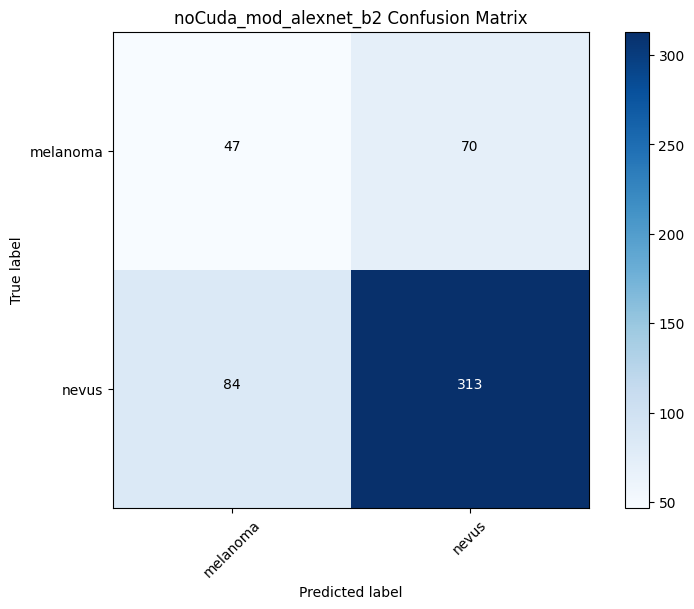

In [ ]:
# Settings
model_name = "noCuda_mod_alexnet_b2"
plot_model_name = model_name
datasets_name = "melanoma_dataset"
print(blue(f"Generating Confusion matrix of {model_name}"))

# Prepare test images dataloader
print(" - Loading dataset", end=" ")
dataset_test_directory = f"datasets/{datasets_name}/test"
test_loader, class_names = prepare_dataloader(dataset_test_directory)
print(blue("✔"))

# Load model
print(" - Loading model", end=" ")
model, device = load_model(model_name)
print(blue("✔"))

# Evaluate and compute confusion matrix
preds, labels = evaluate_model(model, test_loader, device)
conf_matrix = confusion_matrix(labels, preds)
print(f" - Evaluating model {blue('✔')}")

# Plot the confusion matrix
print(f"Done {blue('✔')}")
plot_confusion_matrix(plot_model_name, conf_matrix, class_names)